# Modelling extreme rain accumulation with an application to the 2011 Lake Champlain flood

Jonathan Jalbert, Orla A. Murphy, Christian Genest and Johanna G. Nešlehová

Published in the *Journal of the Royal Statistical Society: Series C (Applied Statistics)* 

https://rss.onlinelibrary.wiley.com/doi/epdf/10.1111/rssc.12342?author_access_token=icy-lf3ecbfarpev1PazA4ta6bR2k8jH0KrdpFOxC64BfY4HGGrdM-rWA3KUaVRfPV8E-jtipTYZdd8JKAzJVg_B4PnEaSWzZFf_Syrr97IBGT3I0TcQ8uMloqZ4P0jy

**Abstract**

A simple strategy is proposed to model total accumulation in non-overlapping clusters of extreme values from a stationary series of daily precipitation. Assuming that each cluster contains at least one value above a high threshold, the cluster sum $S$ is expressed as the ratio $S = M/P$ of the cluster maximum $M$ and a random scaling factor $P \in (0,1]$. The joint distribution for the pair $(M, P)$ is then specified by coupling marginal distributions for $M$ and $P$ with a copula. While the excess distribution of $M$ is well approximated by a generalized Pareto distribution, it is argued that conditional on $P < 1$, a scaled Beta distribution may already be sufficiently rich to capture the behaviour of $P$. An appropriate copula for the pair $(M,P)$ can also be selected by standard rank-based techniques. This approach is used to analyse rainfall data from Burlington, Vermont, and to estimate the return period of the Spring $2011$ precipitation accumulation which was a key factor in that year's devastating flood in the Richelieu Valley Basin in Québec, Canada.

___

This file provides the code written in Julia for the random scale model.

**Outline:**
1. Preparation of the data
2. Exploratory data analysis
3. The random scale model
4. Computing the return level of the spring precipitation accumulation of 2011



In [1]:
using CSV, DataFrames, Dates
using Distributions, StatsBase
using Extremes
using Gadfly, Compose
include("functions.jl");

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/jalbert/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


## 1. Preparation of the data

1. Loading the data
2. Extracting spring precipitation before 2011
3. Extracting cluster of high precipitation
4. Computing spring accumulation


### Loading the data

The data were excerpted from the website of the National Centers for Environmental Information of the US National Oceanic and Atmospheric Administration; see https://www.ncdc.noaa.gov/. For the period $1884$--$1943$, we used the measurements taken at a weather station GHCND:USC00431072 located $3$~km from the airport in Burlington, Vermont. As this station was then closed, we resorted to data collected at the airport itself GHCND:USW00014742 for the years $1944$ to $2010$.

In [2]:
filename = "BurlingtonCatPcp.csv"
data = CSV.read(filename)
dropmissing!(data, disallowmissing=true) # remove lines with missing data if any
first(data,5)

5×2 DataFrame
│ Row │ Date       │ Pcp     │
│     │ Date       │ Float64 │
├─────┼────────────┼─────────┤
│ 1   │ 1884-01-01 │ 4.6     │
│ 2   │ 1884-01-02 │ 9.7     │
│ 3   │ 1884-01-03 │ 0.5     │
│ 4   │ 1884-01-04 │ 0.0     │
│ 5   │ 1884-01-05 │ 0.0     │

### Extracting spring precipitation before 2011

Spring precipitation is the precipitation occurring during April, May and June.

In [3]:
ind_year = year.(data[:Date]) .<2011
ind_spring = (month.(data[:Date]) .>=4) .& (month.(data[:Date]) .<=6)

ind = ind_year .& ind_spring

springPcp = data[ind,:]
first(springPcp,5)


5×2 DataFrame
│ Row │ Date       │ Pcp     │
│     │ Date       │ Float64 │
├─────┼────────────┼─────────┤
│ 1   │ 1884-04-01 │ 0.0     │
│ 2   │ 1884-04-02 │ 0.0     │
│ 3   │ 1884-04-03 │ 7.4     │
│ 4   │ 1884-04-04 │ 3.6     │
│ 5   │ 1884-04-05 │ 3.6     │

### Extracting cluster of high precipitation

We defined a *cluster of high precipitation* as a streak (i.e., an uninterrupted sequence) of consecutive days with non-zero precipitation containing at least one value above a high threshold $u$. This way, each cluster is then separated from any other by at least one day without rain. This definition leads to somewhat different clusters than the classical runs method (OBrien, 1987; Smith & Weissman, 1994), which puts threshold exceedances in the same cluster unless they are separated by at least $r$ non-exceedances. An advantage of the present cluster definition is that it allows clusters of high precipitation to start or end with a non-exceedance. This is convenient because rainfall associated with a given weather system may intensify gradually. This was the case for four of the five clusters in Spring 2011.

The threshold corresponds to the 95% quantile of non-zero spring precipitation.

In [4]:
# Computation of the threshold

y = filter(x -> x>0, springPcp[:Pcp])

threshold = quantile(y,.95)

21.6

In [5]:
cluster = getcluster(springPcp,threshold)
last(cluster,5)

5×5 DataFrame
│ Row │ Begin      │ Length │ Max     │ Sum     │ P        │
│     │ Date       │ Int64  │ Float64 │ Float64 │ Float64  │
├─────┼────────────┼────────┼─────────┼─────────┼──────────┤
│ 1   │ 2008-06-19 │ 6      │ 32.3    │ 46.8    │ 0.690171 │
│ 2   │ 2009-05-09 │ 2      │ 45.2    │ 54.1    │ 0.83549  │
│ 3   │ 2009-05-16 │ 2      │ 26.2    │ 28.2    │ 0.929078 │
│ 4   │ 2010-06-05 │ 2      │ 33.0    │ 53.8    │ 0.613383 │
│ 5   │ 2010-06-22 │ 3      │ 24.6    │ 29.7    │ 0.828283 │

### Computing spring accumulations

In [6]:
springAcc = DataFrame(Year = Int64[], Total = Float64[], Extreme = Float64[], NonExtreme = Float64[])

yearObs = unique(year.(springPcp[:Date]))

for yrs in yearObs
   
    ind = year.(springPcp[:Date]) .== yrs
    y = springPcp[ind,:Pcp]
    
    accumulation = sum(y)
    
    indCluster = year.(cluster[:Begin]) .== yrs
    
    if any( indCluster )
        extremeAccumulation = sum(cluster[indCluster,:Sum])
    else
        extremeAccumulation = 0.0
    end
    
    nonExtremeAccumulation = accumulation - extremeAccumulation
    
    push!(springAcc, [yrs, accumulation, extremeAccumulation, nonExtremeAccumulation])
    
end

last(springAcc,5)

5×4 DataFrame
│ Row │ Year  │ Total   │ Extreme │ NonExtreme │
│     │ Int64 │ Float64 │ Float64 │ Float64    │
├─────┼───────┼─────────┼─────────┼────────────┤
│ 1   │ 2006  │ 426.7   │ 316.4   │ 110.3      │
│ 2   │ 2007  │ 203.6   │ 92.2    │ 111.4      │
│ 3   │ 2008  │ 247.9   │ 73.7    │ 174.2      │
│ 4   │ 2009  │ 314.2   │ 82.3    │ 231.9      │
│ 5   │ 2010  │ 265.8   │ 83.5    │ 182.3      │

## 2. Exploratory data analysis

1. Cluster of high precipitation properties
2. Spring accumulation properties

### 2.1 Cluster of high precipitation properties

The following figures show the relation between the Peak-to-Sum ratio and the cluster sum.

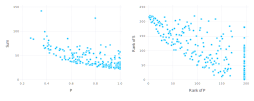

In [7]:
# scatter plot between Peak-to-sum ratio and the maximum
f1 = plot(cluster, x=:P, y=:Sum, Geom.point, Coord.cartesian(xmin=.2))

# Rankplot between Peak-to-sum ratio and the maximum
r₁ = tiedrank(cluster[:P])
r₂ = tiedrank(cluster[:Sum])
f2 = plot(x=r₁, y=r₂, Geom.point, Guide.xlabel("Rank of P"), Guide.ylabel("Rank of S"))

set_default_plot_size(10inch, 4inch)
gridstack([f1 f2])

The following figures show the relation between the Peak-to-Sum ratio and the cluster maxima.

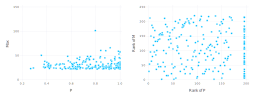

In [8]:
# scatter plot between Peak-to-sum ratio and the maximum
f1 = plot(cluster, x=:P, y=:Max, Geom.point, Coord.cartesian(xmin=.2))

# Rankplot between Peak-to-sum ratio and the maximum
r₁ = tiedrank(cluster[:P])
r₂ = tiedrank(cluster[:Max])
f2 = plot(x=r₁, y=r₂, Geom.point, Guide.xlabel("Rank of P"), Guide.ylabel("Rank of M"))

set_default_plot_size(10inch, 4inch)
gridstack([f1 f2])

The last figure shows the rank plot derived from the $172$ pairs $(M_i, P_i)$ of cluster maxima and Peak-to-Sum ratios for which $P_i < 1$. One cannot discern any particular pattern in the plot, which suggests that the assumption of independence between $M$ and $P$ given $P < 1$ seems appropriate at threshold level $u = 21.6$~mm. This conclusion is further supported by a $p$-value of $0.76$ for the consistent Cramér-von Mises test of independence based on the $L_2$ distance between the product copula $\Pi$ and an asymptotically unbiased rank-based estimate of the true underlying copula $D$; for details about this test, available in the R package *copula*, see Genest & Rémillard, (2004). In contrast, modelling the dependence between $P$ and $S$ would be much more challenging, as evidenced by the rank plot of the cell before.

### 2.2 Spring accumulation properties

In the Lake Champlain watershed, the value $T$ of the spring precipitation accumulation is the main contributing factor to floods. The value of $T$ observed in $2011$ was very high: $510$~mm. Because of the presence of extreme rainfall, it is natural to regard $T$ as the sum $Z + W$ of two independent components, namely the accumulation $Z$ of non-extreme rainfall and the accumulation $W$ of precipitation from the clusters of high precipitation. For any given year $k \in \{ 1,\dots, 127 \}$ between $1884$ and $2010$, the observed value $Z_k$ is simply the total precipitation accumulation in year $k$ minus the accumulation $W_k$ of rain from clusters of high precipitation in the same year.

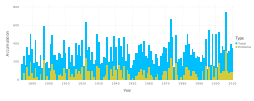

In [9]:
df = springAcc[[:Year, :Total, :Extreme]]
df = melt(df, :Year)
rename!(df, :variable => :Type, :value => :Accumulation)
plot(df, x=:Year, y=:Accumulation, color=:Type, Geom.bar, Coord.cartesian(xmin=1884, xmax=2010),
Guide.xticks(ticks=collect(1890:10:2010)))

## 3. The random scale model

1. Estimating the distribution of the cluster maxima
2. Estimating the distribution of the Peak-to-Sum ratio
3. Simulation of cluster sums

### 3.1 Estimating the cluster maxima distribution

As stated in Section 2.2 of the paper, suppose that the excess distribution $F_u$ of cluster maxima is GPD with scale $\sigma > 0$ and shape $\xi \in \mathbb{R}$. Further assume an improper prior for these parameters given, for all $\sigma>0$ and $\xi \in \mathbb{R}$, by $f_{(\sigma,\xi)}(\sigma,\xi) \propto 1/\sigma$. A sample of the posterior is obtain in the following cell.


Acceptation rate for ϕ is 0.608
Acceptation rate for ξ is 0.4973


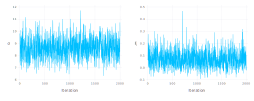

In [10]:
fd_clusterMaxima = gpdfitbayes(cluster[:Max], threshold=threshold, niter=15000, warmup=5000, thin=5)

mcmcClusterMaxima = DataFrame(Iteration = 1:length(fd_clusterMaxima), σ = scale.(fd_clusterMaxima), 
    ξ = shape.(fd_clusterMaxima))

f1 = plot(mcmcClusterMaxima, x=:Iteration, y=:σ, Geom.line)
f2 = plot(mcmcClusterMaxima, x=:Iteration, y=:ξ, Geom.line)

set_default_plot_size(10inch, 4inch)
gridstack([f1 f2])


The Bayesian QQ-plot displayed in the next cell suggests an adequate fit, though the most extreme precipitation observation is underestimated. To further check the adequacy of this model, the fitted distribution $F_u$ was used to estimate at $66$ years the return period for the extreme rainfall of $69.6$~mm that occurred on $26$ April $2011$. This may seem low, but it does make good sense given that rainfalls of similar (or even higher) magnitude had already been recorded in the past. 


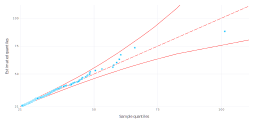

In [11]:
df_QQplot = qqestimation(cluster[:Max], fd_clusterMaxima)
df_CI = qqci(collect(range(1/1000,stop=9999/10000,length=300)),fd_clusterMaxima)

set_default_plot_size(10inch, 5inch)
qqpl = layer(df_QQplot, x = :Q, y = :Q̂, Geom.point, Geom.abline(color="red", style=:dash))
qsup = layer(df_CI, x = :Qmean, y=:Qsup, Geom.line, Theme(default_color="red"))
qinf = layer(df_CI, x = :Qmean, y=:Qinf, Geom.line, Theme(default_color="red") )

plot(qqpl,qsup,qinf, Coord.Cartesian(xmin=21.6, ymin=21.6, xmax = 110, ymax = 110),
Guide.xlabel("Sample quantiles"), Guide.ylabel("Estimated quantiles"),
Guide.xticks(ticks=[21 50 75 100]), Guide.yticks(ticks=[21 50 75 100]))

### 3.2 Estimating the peak to sum ratio P distribution

The first step is to estimate the Peak-to-Sum ratio when P<1 with the non-standard beta distribution. The next cell provide a sample of the posterior distribution of the Peak-to-Sum ratio conditional on $P<1$. The distribution of $P|P<1$ is modeled with non-standard beta distribution.

Acceptation rate for μ is 0.5328
Acceptation rate for ν is 0.4191
Acceptation rate for θ is 0.4859


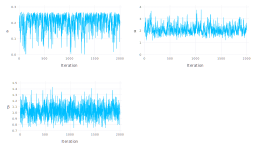

In [12]:
P = cluster[:P]

fd_Plt1 = nsbetabayesfit(P[P .< 1], niter=15000, warmup=5000, thin=5, stepSize=[.03, .75, .05])

a = [params(fd_Plt1[i])[1] for i=1:length(fd_Plt1)]
α = [params(fd_Plt1[i])[3] for i=1:length(fd_Plt1)]
β = [params(fd_Plt1[i])[4] for i=1:length(fd_Plt1)]

mcmcPlt1 = DataFrame(Iteration = 1:length(fd_Plt1), a = a, α=α, β = β)

f1 = plot(mcmcPlt1, x=:Iteration, y=:a, Geom.line)
f2 = plot(mcmcPlt1, x=:Iteration, y=:α, Geom.line)
f3 = plot(mcmcPlt1, x=:Iteration, y=:β, Geom.line)

set_default_plot_size(10inch, 6inch)
gridstack(Union{Plot,Compose.Context}[f1 f2; f3 Compose.context()])

The posterior for the lower bound $\theta$ is insensitive to this choice of prior (not shown). The  QQ-plot of the fitted $1$-inflated scaled Beta distribution is displayed in the next cell. It suggests a good fit, particularly in the lower tail. This is important because low values of $P$ typically correspond to long clusters with several days of heavy~rain. The Bayesian point estimates of the $1$-inflated scaled Beta distribution are $\hat \theta = 0.205$, $\hat \alpha = 1.92$, $\hat \beta = 1.14$, and $\hat \omega = 0.207$. 

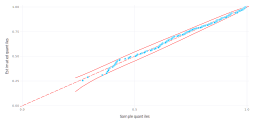

In [13]:
df_QQplot = qqestimation(P[P .< 1], fd_Plt1)
df_CI = qqci(collect(range(1/1000,stop=9999/10000,length=300)),fd_Plt1)

set_default_plot_size(10inch, 5inch)
qqpl = layer(df_QQplot, x = :Q, y = :Q̂, Geom.point, Geom.abline(color="red", style=:dash))
qsup = layer(df_CI, x = :Qmean, y=:Qsup, Geom.line, Theme(default_color="red"))
qinf = layer(df_CI, x = :Qmean, y=:Qinf, Geom.line, Theme(default_color="red") )

plot(qqpl,qsup,qinf,Guide.xlabel("Sample quantiles"), Guide.ylabel("Estimated quantiles"))

### Estimating the rate of cluster of length 1

To obtain the distirbution of the Peak-to-Sum ratio, the probability of a cluster pf length 1, *i.e* $P=1$ has to be added. Assuming a binomial distribution for the number of clusters of length 1 with an improprer prior on the success probability gives the following posteriori distribution. 

In [14]:
n₀ = count(P .< 1)
n₁ = length(P)-n₀
distW1 = Beta(n₁,n₀)

Beta{Float64}(α=49.0, β=171.0)

### 3.3 Sample cluster sums

The next figure provides an additional diagnostic plot attesting to the good fit of the Random Scale Model. It displays the QQ-plot of the cluster sums in which the theoretical quantiles were computed by a Monte Carlo procedure. The fit of the cluster sum distribution derived from the Random Scale Model is acceptable; in spite of a light overestimation in the interval $(80, 120)$, the right tail is well estimated.

In [15]:
M̃ = rand.(fd_clusterMaxima)
P̃ = rand.(fd_Plt1)
λ = rand(distW1, length(P̃))
Z = rand.(Bernoulli.(λ))
P̃[Z] .= 1.0
S̃ = M̃ ./ P̃;

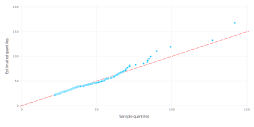

In [16]:
df_QQplot = qqestimation(cluster[:Sum], S̃)

set_default_plot_size(10inch, 5inch)
plot(df_QQplot, x = :Q, y = :Q̂, Geom.point, Geom.abline(color="red", style=:dash),
    Guide.xlabel("Sample quantiles"), Guide.ylabel("Estimated quantiles"))


## 4. Computing the return level of the spring precipitation accumulation of 2011

1. Estimation of the distribution of non-extreme rainfall
2. Simulation of extreme accumulation rainfall
3. Simulation of spring accumulation
4. Computing the return level (Monte Carlo)

### 4.1 Estimation of the distribution of non-extreme rainfall

Because $Z_k$ is a sum of daily rainfall amounts, none of which is extreme, and given that the entire series is stationary, it seems reasonable to assume that $Z_1, \ldots, Z_{127}$ form a Normal random sample. This assumption was validated using a Shapiro--Wilk Normality test ($p$-value $\approx 0.67$). The predictive distribution of the accumulation $Z$ of non-extreme rainfall was found to be Student $t$ with  $n-1=126$ degrees of freedom, location $\bar{z}=161.3$, and scale $ \sqrt{(n+1)s^2/n}$ with $s=40.3$.  These Bayesian estimates were obtained using the reference prior defined, for all $\tau > 0$, by $f_{(\nu, \tau)}\propto 1/\tau^2$. Here we use the Normal distribution as an approximation of the Student with 126 degrees of freedom for the predictive distribution of Z.

In [17]:
z̄ = mean(springAcc[:NonExtreme])
s = std(springAcc[:NonExtreme])

fd_Z = Normal(z̄,s)

Normal{Float64}(μ=161.3173228346457, σ=40.530249519454436)

From the QQ-plot of non-extreme accumulations displayed in the cell, the fit is good.

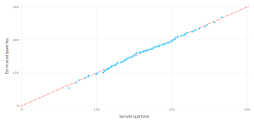

In [18]:
df_QQplot = qqestimation(springAcc[:NonExtreme], fd_Z)

set_default_plot_size(10inch, 5inch)
plot(df_QQplot, x = :Q, y = :Q̂, Geom.point, Geom.abline(color="red", style=:dash),
    Guide.xlabel("Sample quantiles"), Guide.ylabel("Estimated quantiles"))

### 4.2 Simulation of extreme precipitation accumulation

First, the number of high precipitation clusters in a given spring has to be sampled. According to the random scale model, the number of clusters is distributed according to the Poisson distribution.

In [19]:
fd_λ = Gamma(220,1/11557) 

W̃ = Float64[]

for i=1:1000
    λ = rand(fd_λ) 
    n = rand(Poisson(91*λ))
    clusterSum = sample(S̃,n)
    push!(W̃, sum(clusterSum))
    
end


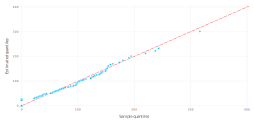

In [20]:
df_QQplot = qqestimation(springAcc[:Extreme], W̃)

set_default_plot_size(10inch, 5inch)
plot(df_QQplot, x = :Q, y = :Q̂, Geom.point, Geom.abline(color="red", style=:dash),
    Guide.xlabel("Sample quantiles"), Guide.ylabel("Estimated quantiles"))

### 4.3 Simulation of spring accumulation

Spring accumulation $T$ is the sum of non-extreme accummulation $Z$ and extreme accumulation $W$.

In [21]:
T̃ = Float64[]

for i=1:1000000
   
    # Generate non-extreme accumulation
    Z̃ = rand(fd_Z)
    
    # Generate extreme accumulation
    λ = rand(fd_λ) 
    n = rand(Poisson(91*λ))
    clusterSum = sample(S̃,n)
    
    # Sum of the two components
    push!(T̃, Z̃ + sum(clusterSum))
   
end

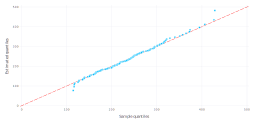

In [22]:
df_QQplot = qqestimation(springAcc[:Total], T̃)

set_default_plot_size(10inch, 5inch)
plot(df_QQplot, x = :Q, y = :Q̂, Geom.point, Geom.abline(color="red", style=:dash),
    Guide.xlabel("Sample quantiles"), Guide.ylabel("Estimated quantiles"))

### 4.4 Estimation the return level of the 2011 spring accumulation

Estimation by Monte Carlo

In [23]:
returnPeriod = length(T̃)/count(T̃.>510)

497.0178926441352